In [1]:
import os 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np
import cv2

In [9]:
#import pip
#pip.main(['install','opencv-python','-i','https://pypi.tuna.tsinghua.edu.cn/simple'])

#### Make .tfrecords files for high efficency I/O

In [2]:
#path = 'surface/'    #where you store your data
classes = {'img_0'}    #setting the classes
writer= tf.python_io.TFRecordWriter("surface_train.tfrecords") #initialize a writer to record
 
for index,name in enumerate(classes):
    #class_path=path+name+'/'
    class_path = name+'/'
    for img_name in os.listdir(class_path): 
        if img_name.endswith('.jpg'):
            #print(img_name)
            img_path=class_path+img_name #每一个图片的地址
            img=cv2.imread(img_path,0)
            #print(img.shape)
            #img= img.resize((28,28))
            #print(type(img))
            img_raw=img.tobytes()#将图片转化为二进制格式
            example = tf.train.Example(features=tf.train.Features(feature={
            "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[index])),
            'img_raw': tf.train.Feature(bytes_list=tf.train.BytesList(value=[img_raw]))
            })) #example对象对label和image数据进行封装
            writer.write(example.SerializeToString())  #序列化为字符串

writer.close()
#https://www.2cto.com/kf/201702/604326.html

#### Read .tfrecords file into iter

In [16]:
#https://blog.csdn.net/qwe2508/article/details/80680640
def read_and_decode(file_name,shuffle=True):
    def parser(record):
        features = tf.parse_single_example(record,
                                           features={
                                               'label': tf.FixedLenFeature([], tf.int64),
                                               'img_raw': tf.FixedLenFeature([], tf.string),
                                           })  # return image and label
        image = tf.decode_raw(features['img_raw'], tf.uint8)
        img = tf.reshape(image, [28, 28, 1])
        img = tf.cast(img, tf.float32)
        '''
        height = image_size
        width = image_size
        # Randomly crop a [height, width] section of the image.随机裁剪
        distorted_image = tf.random_crop(img, [height, width, 1])
        # Randomly flip the image horizontally.随机翻转
        distorted_image = tf.image.random_flip_left_right \
            (distorted_image)
        # 改变亮度
        distorted_image = tf.image.random_brightness(distorted_image,
                                                     max_delta=63)
        # 改变对比度
        distorted_image = tf.image.random_contrast(distorted_image,
                                                   lower=0.2, upper=1.8)
        img = tf.image.per_image_standardization(distorted_image)
        '''
        label = tf.cast(features['label'], tf.int32)
        return img,label
    
    batch_size = 32
    dataset = tf.data.TFRecordDataset(file_name)
    if shuffle:
        dataset = dataset.map(parser).repeat().batch(batch_size).shuffle(buffer_size=1000)
    else:
        dataset = dataset.map(parser).repeat().batch(batch_size)

    iterator = dataset.make_one_shot_iterator()

    img_input, label = iterator.get_next()
    return img_input,label

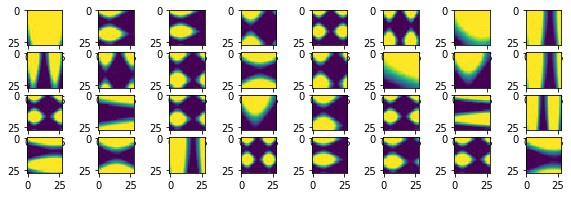

In [29]:
images_train, labels_train = read_and_decode('surface_train.tfrecords')
with tf.Session() as sess:
    for i in range(3):
        imgs = sess.run(images_train)
#        print(imgs.shape)
#        plt.imshow(imgs[0].reshape((28,28)))
#        break
        f, a = plt.subplots(4, 8, figsize=(10, 3))
        #f.suptitle('h1 = %d,h2=%d,h3=%d,epochs is %d, RMSE is %f'%(n_hidden_1,n_hidden_2,n_hidden_3,training_epochs,RMSE), fontsize=16)
        for i in range(8):
            a[0][i].imshow(np.reshape(imgs[4*i], (28, 28)))
            a[1][i].imshow(np.reshape(imgs[4*i+1], (28, 28)))
            a[2][i].imshow(np.reshape(imgs[4*i+2],(28,28)))
            a[3][i].imshow(np.reshape(imgs[4*i+3],(28,28)))
        #plt.savefig("%d_%d_%d_001_%d_RMSE.png"%(n_hidden_1,n_hidden_2,n_hidden_3,training_epochs))    #要在show前调用
        plt.show()
        break
    


In [2]:
'''
def read_and_decode(filename): # 读入dog_train.tfrecords
    filename_queue = tf.train.string_input_producer([filename])#生成一个queue队列

    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)#返回文件名和文件
    features = tf.parse_single_example(serialized_example,
                                       features={
                                           'label': tf.FixedLenFeature([], tf.int64),
                                           'img_raw' : tf.FixedLenFeature([], tf.string),
                                       })#将image数据和label取出来

    img = tf.decode_raw(features['img_raw'], tf.uint8)
    img = tf.reshape(img, [28, 28, 1])  #reshape为128*128的3通道图片
    #img = tf.cast(img, tf.float32) * (1. / 255) - 0.5 #在流中抛出img张量
    img = tf.image.per_image_standardization(img)
    label = tf.cast(features['label'], tf.int32) #在流中抛出label张量
    return img, label
#https://www.cnblogs.com/upright/p/6136265.html'''

In [32]:
'''#http://machinelearninguru.com/deep_learning/tensorflow/basic/tfrecord/tfrecord.html
def parse_data(data):
    feats = tf.parse_single_example(data, features={'img_raw':tf.FixedLenFeature([], tf.string),'label':tf.FixedLenFeature([],tf.int64)})
    image = tf.decode_raw(feats['img_raw'], tf.float32)
    label = feats['label']
    return image, label
dataset = tf.data.TFRecordDataset('surface_train.tfrecords')
dataset = dataset.map(parse_data)
iterator = dataset.make_one_shot_iterator()
next_element = iterator.get_next()
with tf.Session() as sess:
    value = sess.run(next_element)
    #print(value)
    
#https://blog.csdn.net/kwame211/article/details/78579035
#https://blog.csdn.net/amao1998/article/details/81260341
'''

In [33]:
#设置参数
learning_rate = 0.01
training_epochs = 20000
batch_size = 256
display_step = 1
examples_to_show = 10
n_input = 784

In [34]:
# tf Graph input (only pictures)
X = tf.placeholder("float", [None, n_input])
keep_prob = tf.placeholder(tf.float32)    #set dropout prob

In [36]:
# 用字典的方式存储各隐藏层的参数
n_hidden_1 = 256 # 第一编码层神经元个数
n_hidden_2 = 64 # 第二编码层神经元个数
n_hidden_3 = 32 # 第三编码层神经元个数

# 权重和偏置的变化在编码层和解码层顺序是相逆的
# 权重参数矩阵维度是每层的 输入*输出，偏置参数维度取决于输出层的单元数
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    'encoder_h3': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_3])),
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_3, n_hidden_2])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h3': tf.Variable(tf.random_normal([n_hidden_1, n_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    'encoder_b3': tf.Variable(tf.random_normal([n_hidden_3])),
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_2])),
    'decoder_b2': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b3': tf.Variable(tf.random_normal([n_input])),
}

In [37]:
# 每一层结构都是 xW + b
# 构建编码器
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_1 = tf.nn.dropout(layer_1,keep_prob=0.9)    #dropout = 0.9
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                   biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                   biases['encoder_b3']))
    return layer_3

# 构建解码器
def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    #print(layer_1.get_shape())
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    #print(layer_2.get_shape())
    #print(weights["decoder_h3"].get_shape())
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                   biases['decoder_b3']))
    #print(layer_3.get_shape())
    return layer_3
 
# 构建模型
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)
 
# 预测
y_pred = decoder_op
y_true = X
 
# 定义代价函数和优化器
current_iter = tf.Variable(0)    #设置优化器学习率衰减
total_cost = []                  #画衰减曲线
lr = tf.train.exponential_decay(learning_rate,current_iter,training_epochs,0.99)
#lr = tf.train.polynomial_decay(learning_rate,current_iter,training_epochs,0.99)
#lr_decay https://blog.csdn.net/akadiao/article/details/79560731
#lr_decay https://zhuanlan.zhihu.com/p/32923584
#lr_decay https://www.e-learn.cn/content/qita/736149
cost = 784 * tf.reduce_mean(tf.pow(y_true - y_pred, 2)) #最小二乘法
#cost = tf.pow(y_true - y_pred, 2)    #新的损失函数
optimizer = tf.train.AdamOptimizer(lr).minimize(cost,current_iter)

In [ ]:
#with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as sess:
with tf.Session() as sess:
    #with tf.device("/gpu:0"):  #GPU 没用？？？
    # tf.initialize_all_variables() no long valid from
    # 2017-03-02 if using tensorflow >= 0.12
    # 加上下面一行就可以使用 个gpu了
    #config = tf.ConfigProto(allow_soft_placement=True)
    # 这一行设置 gpu 随使用增长
    #config.gpu_options.allow_growth = True   #？数据上传GPU~~

    if int((tf.__version__).split('.')[1]) < 12 and int((tf.__version__).split('.')[0]) < 1:
        init = tf.initialize_all_variables()
    else:
        init = tf.global_variables_initializer()
    sess.run(init)

    # 首先计算总批数，保证每次循环训练集中的每个样本都参与训练，不同于批量训练
    total_batch = int(mnist.train.num_examples/batch_size) #总批数
    for epoch in range(training_epochs):
        current_iter +=1
        #print("Current learning rate is",lr.eval(session=sess))
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)  # max(x) = 1, min(x) = 0
            # Run optimization op (backprop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict={X: batch_xs,keep_prob:0.5})
        if epoch % display_step == 0:
            print("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(c))
        total_cost.append(c)    #log cost change
    print("Optimization Finished!")



    ####################################################################################
    #测试和计算结果，这里馈入数据十个
    encode_decode = sess.run(y_pred, feed_dict={X: mnist.test.images[:100*examples_to_show],keep_prob:1})

    #计算均方根值
    ERR = 0    #图与图之间的整体误差
    for i in range(100*examples_to_show):
        err_img = mnist.test.images[i]-encode_decode[i]
        #print('mnist',mnist.test.images[i].max())    #max is 1.0
        #print('endecoder',encode_decode[i].mean())
        #print('endecoder',encode_decode[i].max())
        #print('err_max',err_img.max())
        err_img = err_img**2
        err_sqrt = np.sqrt(err_img.sum()/n_input)
        #print("err is",err_sqrt)

        #计算总误差
        ERR = err_sqrt + ERR
        RMSE = ERR/(100*examples_to_show)

    print("RMSE is ",RMSE)    #计算平均RMES



    #选出十个指标用于显示
    f, a = plt.subplots(3, 10, figsize=(10, 3))
    f.suptitle('h1 = %d,h2=%d,h3=%d,epochs is %d, RMSE is %f'%(n_hidden_1,n_hidden_2,n_hidden_3,training_epochs,RMSE), fontsize=16)
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[9*examples_to_show+i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[9*examples_to_show+i], (28, 28)))
        a[2][i].imshow(np.reshape(np.abs((mnist.test.images[9*examples_to_show+i]-encode_decode[9*examples_to_show+i])),(28,28)))
    plt.savefig("%d_%d_%d_001_%d_RMSE.png"%(n_hidden_1,n_hidden_2,n_hidden_3,training_epochs))    #要在show前调用
    plt.show()


In [ ]:
plt.plot(total_cost)
plt.title('AutoEncoder Cost Change')
plt.xlabel('Epochs')
plt.ylabel("Cost")
plt.savefig("%d_%d_%d_001_%d_Cost.png"%(n_hidden_1,n_hidden_2,n_hidden_3,training_epochs)) 
plt.show()

In [ ]:
saver = tf.train.Saver()